# Integrating the value function correctly

Right now I'm using the generic `scipy.integrate.quad`, which is probably slow (tons of integration points)
and not precise.

It seems it also struggles with some values of lambdas and p.

Objectives:

1. Write a Gauss-Hermite integration procedure
2. Check for accuracy against `scipy.integrate.quad`
3. Check for lambdas, p points where the integration struggles


The integration is over future states of log demand.

$$ \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) b_t(x_{t+1}| a_t, I_t )\; d x_{t+1} = \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) \left[\sum_{l=1}^L p_l(x_{t+1}) \lambda_l\right] \; d x_{t+1} $$

$$ = \sum_{l=1}^L \left[ \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \right] * \lambda_l $$

Since $p_l(x_{t+1})$ is a normal pdf, it makes sense to use Gauss-Hermite integration for each element of the sum above (See Judd(1998) "Numerical Methods in Economics", page 261ff):

$$\int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \approx \pi^{-1/2} \sum_{i=1}^n w_i V(\sqrt{2} \sigma x_i + \mu_l)$$

where $x_i, w_i$ are Gauss-Hermite collocation points and weights and

$$ \mu_l = \alpha + \beta_l \log p_t $$

According to Judd (1998), ~7 nodes might be enough to get a low error.

The sample points and weights are obtained from https://keisan.casio.com/exec/system/1281195844


In [15]:
import sys
sys.path.append("../")
sys.path.append("../examples")
import src
import src.constants as const
import scipy.integrate as integrate
from aguirregabiria_simple import v0
import numpy as np
from typing import Callable
import dill


lambdas = src.generate_simplex_3dims(4)
rand_n = np.random.randint(0, high=len(lambdas))

r_lambda_point = lambdas[rand_n]
print(r_lambda_point)

[0.33333333 0.         0.66666667]


In [12]:
v0(r_lambda_point[:-1])

1.5781220395313127

In [71]:
i = 1
length_of_price_grid = 10
min_price, max_price = 0.5, 1.5
dmd_transition_fs = src.dmd_transition_fs
update_lambdas = src.update_lambdas
belief = src.belief
wGuess = v0
p_array = np.linspace(min_price, max_price, num=length_of_price_grid) 


for i in range(len(p_array)):
    def new_lambdas(new_dmd):
        return update_lambdas(new_dmd, transition_fs=dmd_transition_fs,
                              old_lambdas=r_lambda_point, action=p_array[i], old_state=2.5)

    def new_belief(new_dmd):
        return belief(new_dmd, transition_fs=dmd_transition_fs,
                      lambda_weights=new_lambdas(new_dmd),
                      action=p_array[i], old_state=2.5)

    def integrand(new_dmd):
        return wGuess(new_lambdas(new_dmd)[:-1]) * new_belief(new_dmd)

    logd_min, logd_max = -6, 2.3
    integrated_values, error = integrate.quad(integrand, logd_min, logd_max)
    print(p_array[i], integrated_values)

0.5 0.631024495018474
0.6111111111111112 1.0655317792069745
0.7222222222222222 1.408790405013018
0.8333333333333333 1.547989512778736
0.9444444444444444 1.5690930523692548
1.0555555555555556 1.581271416625236
1.1666666666666665 1.613960005753253
1.2777777777777777 1.6656161410960948
1.3888888888888888 1.7301458683810182
1.5 1.802197280357906


In [27]:
hermite_xs = np.array([-2.6519613568352334924470820065166161144,
-1.6735516287674714450318013983035948191,
             -0.81628788285896466303871095902714581674, 0., 0.8162878828589646630387109590271458167,
1.6735516287674714450318013983035948191, 2.6519613568352334924470820065166161144])

hermite_ws = np.array([9.717812450995191541494242559389596444E-4,
0.054515582819127030592178568841695125961,
0.42560725261012780052031746666639103544,
0.8102646175568073267648765638130949407,
0.42560725261012780052031746666639103544,
0.054515582819127030592178568841695125961,
9.717812450995191541494242559389596444E-4])


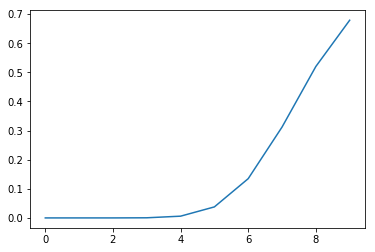

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
new_beliefs_vals = []
rescaled_demands = rescale_demand(hermite_point, beta_l, p_array) 
for dmd in rescaled_demand:
    new_beliefs_vals.append(new_belief(dmd))

fig, ax = plt.subplots(1, 1)
ax.plot(new_beliefs_vals)

In [73]:
hermite_point = hermite_xs[4]
beta_l = const.betas_transition[0]
rescaled_demand = rescale_demand(hermite_point, beta_l, p_array) 

In [68]:

sqrt2 = np.sqrt(2)

def rescale_demand(dmd, beta_l, price):
    """
    Rescales demand to use Gauss-Hermite collocation points
    """
    mu = const.α + beta_l*np.log(price)
    return sqrt2*const.σ_ɛ * dmd + mu

def gauss_hermite_integrate(f, price, lambdas, hermite_xs, hermite_ws):
    """
    Integrates f with Guass-Hermite
    """
    sum_over_each_lambda = 0.
    for l, beta_l in enumerate(const.betas_transition):
        for k, hermite_point in enumerate(hermite_xs):
            rescaled_demand = rescale_demand(hermite_point, beta_l, price)            
            new_lambdas_value = new_lambdas(rescaled_demand)
            v_value = f(new_lambdas_value[:-1])
            sum_over_each_lambda += f(new_lambdas_value[:-1])*hermite_ws[k]*lambdas[l]
    
    return np.pi**(-0.5)*sum_over_each_lambda

for p in p_array:
    value = gauss_hermite_integrate(v0, p, r_lambda_point, hermite_xs, hermite_ws)
    print(p, value)

0.5 1.540538487546959
0.6111111111111112 1.5412983271058178
0.7222222222222222 1.542844294800158
0.8333333333333333 1.5455895405341928
0.9444444444444444 1.549941731243946
1.0555555555555556 1.556191064245976
1.1666666666666665 1.5644198431233203
1.2777777777777777 1.57447818801118
1.3888888888888888 1.5860291293381144
1.5 1.5986316409838996


In [62]:
hermite_point = hermite_xs[4]
beta_l = const.betas_transition[0]
np.e**rescale_demand(hermite_point, beta_l, p_array) 

array([38.73115206, 21.21338081, 12.85162032,  8.36592885,  5.74699977,
        4.11649072,  3.04880789,  2.32062216,  1.80704063,  1.43448711])

In [38]:
p_array[8]

1.3888888888888888

$$\int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \approx \pi^{-1/2} \sum_{i=1}^n w_i V(\sqrt{2} \sigma x_i + \mu_l)$$

In [29]:
rescale_demand(hermite_xs, -3, price=1.4)

array([-1.88463657, -1.19279642, -0.58661941, -0.00941671,  0.56778599,
        1.173963  ,  1.86580315])

In [23]:
const.betas_transition

array([-3. , -2.5, -2. ])